In [1]:
import json
from abc import abstractmethod
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

from prep import Reader, Preprocessor, SentenceTransformerEmbedding
from clusterers import KMeansClusterer, AgglomerativeClusterer, HDBSCANClusterer


In [6]:
class Config:
    def __init__(self):
        self.link_to_dataset = 'decahose_polls_2021-08_100k.txt'

        self.only_english = True
        self.only_retweeted = False
        # self.only_retweeted = True
        
        self.KforKMeans = 25

config = Config()

In [10]:
df = Reader(config.link_to_dataset).read()

In [11]:
preprocessor = Preprocessor(df)
preprocessor.preprocess_df(only_english = config.only_english, only_retweeted = config.only_retweeted)
preprocessor.preprocess_text()

df = preprocessor.get_dataframe()

dropping quote_count
dropping contributors
dropping reply_count
dropping favorite_count
dropping retweeted
dropping coordinates
dropping retweet_count
dropping favorited
dropping geo
dropping filter_level

   truncated                                               text  \
0      False  RT @CaesarsSports: Thursday Dingers is coming ...   
1      False  RT @Openly: Should sports bodies allow interse...   
2      False                       RT @TheSkyBlueHub: Defenders   
5      False                 How often do you get your haircut?   
6      False                              Let's settle a debate   

   is_quote_status  in_reply_to_status_id                   id  \
0            False                    NaN  1422682179906199556   
1            False                    NaN  1422682226488188940   
2            False                    NaN  1422682282679226368   
5            False                    NaN  1422682359430885382   
6            False                    NaN  142268237578018816

In [8]:
# df = df.sample(10000)

In [15]:
embeddings = SentenceTransformerEmbedding().embed(df.text)
print(embeddings.shape)

(48865, 384)


K-Means Clustering

In [18]:
clusterer = KMeansClusterer(k = config.KforKMeans)
clusterer.fit(embeddings)

In [19]:
clusterer.summarise_clusters(df, n = 5)

Cluster Number 0 - 
Elements in Cluster: 810
Average Words in the Poll: 21.185185185185187

Samples - 
1. RT @votingunnie: FAST GA (2 HRS) 
#votingunnieGA

The artist who wins will get FREE 10 voting tickets (10 votes) 

#ENHYPEN #TREASURE #EXO…
2. RT @votingunnie: FAST GA (2 HRS) 
#votingunnieGA

The artist who wins will get FREE 10 voting tickets (10 votes) 

#ENHYPEN #TREASURE #EXO…
3. RT @UnnieVoting: VOTE GA (1 day) 

The artist who wins will get FREE 15 voting tickets 

#ENHYPEN #TREASURE #EXO #SECRETNUMBER
4. RT @votingunnie: FAST GA (2 HRS) 
#votingunnieGA

The artist who wins will get FREE 10 voting tickets (10 votes) 

#ENHYPEN #TREASURE #EXO…
5. RT @votingunnie: FAST GA (2 HRS) 
#votingunnieGA

The artist who wins will get FREE 10 voting tickets (10 votes) 

#ENHYPEN #TREASURE #EXO…

Cluster Number 1 - 
Elements in Cluster: 3047
Average Words in the Poll: 17.718083360682638

Samples - 
1. RT @TamilTvExpress: Sunday Evening choice

6pm #Dhanush in Karnan on Zeetamil
6.30pm #T

HDBSCAN Clustering

In [20]:
hdbclusterer = HDBSCANClusterer(min_cluster_size = 500, min_samples = 1)
hdbclusterer.fit(embeddings)

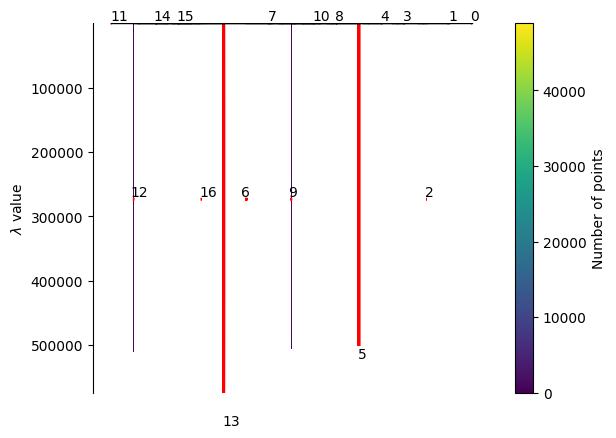

In [21]:
hdbclusterer.plot_dendrogram()

Agglomerative Clustering

In [22]:
agglo_clusterer = AgglomerativeClusterer()
agglo_clusterer.fit(embeddings)

In [23]:
clusterer.summarise_clusters(df)

Cluster Number 0 - 
Elements in Cluster: 810
Average Words in the Poll: 21.185185185185187

Samples - 
1. RT @UnnieVoting: FAST GA (5 HRS) 

The artist who wins will get FREE 10 votes in WH0SFAN - MCD PREVOTE

#TXT  #THEBOYZ #REDVELVET #CRAVITY
2. RT @UnnieVoting: VOTE GA (1 day) 

The artist who wins will get FREE 15 voting tickets 

#ENHYPEN #TREASURE #EXO #SECRETNUMBER
3. RT @UnnieVoting: FAST GA (5 HRS) 

The artist who wins will get FREE 10 votes in WH0SFAN - MCD PREVOTE

#TXT  #THEBOYZ #REDVELVET #CRAVITY
4. RT @votingunnie: FAST GA (2 HRS) 
#votingunnieGA

The artist who wins will get FREE 10 voting tickets (10 votes) 

#ENHYPEN #TREASURE #EXO…
5. RT @UnnieVoting: FAST GA (5 HRS) 

The artist who wins will get FREE 10 votes in WH0SFAN - MCD PREVOTE

#TXT  #THEBOYZ #REDVELVET #CRAVITY
6. RT @votingunnie: FAST GA (2 HRS) 
#votingunnieGA

The artist who wins will get FREE 10 voting tickets (10 votes) 

#ENHYPEN #TREASURE #EXO…
7. RT @UnnieVoting: VOTE GA (1 day) 

The artist who wi

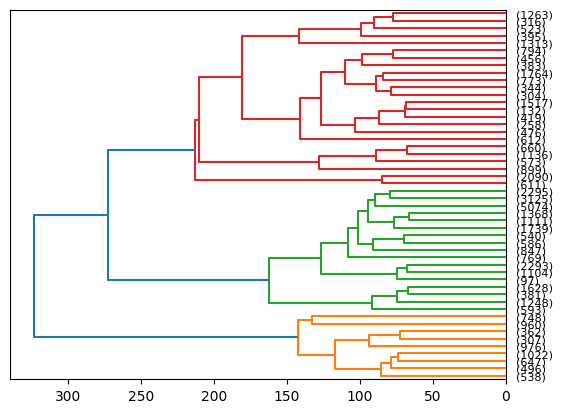

In [24]:
agglo_clusterer.plot_dendrogram(truncate_mode = 'lastp', p = 50)

In [25]:
childs = agglo_clusterer.clusterer.children_
print(childs)

[[17447 17656]
 [17868 48865]
 [39312 48866]
 ...
 [97698 97725]
 [97723 97726]
 [97722 97727]]
